In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Kendi Modüllerimiz
from lstm import sigmoid,tanh_activation,softmax,tanh_derivative # Aktivasyon Fonksiyonları
from lstm import initialize_parameters,initilaize_output_units #Parametreler
from lstm import lstm_cell,output_cell
from lstm import get_embeddings
from lstm import forward_propagation,backward_propagation
from lstm import cal_loss_accuracy
from lstm import calculate_output_cell_error
from lstm import calculate_single_lstm_cell_error
from lstm import calculate_output_cell_derivatives
from lstm import calculate_single_lstm_cell_derivatives
from lstm import calculate_output_cell_error
from lstm import update_parameters,update_embeddings
from lstm import initialize_V
from lstm import initialize_S
from lstm import train,predict,save_model

In [3]:
#path ="./data/lastname_tally.csv" # Türkçe isimler
path = "./data/tutunamayanlar.txt"
with open(path, "r", encoding="utf-8") as file:
    data = file.read()

import re
data = data.split(".")
data = [re.sub(r'[^\w\s]','',x) for x in data]
#data = pd.read_csv(path)

#get names from the dataset
#data['Name'] = data['Name']

#get first 10000 names
data = np.array(data[:10000]).reshape(-1,1)
#%%
#covert the names to lowee case
data = [x.lower() for x in data[:,0]]
data_n = []
for sentence in data:
    sentence = sentence.split(" ")
    #sentence = np.array(sentence).reshape(-1,1)
    data_n.append(sentence)
data = data_n
#%%
data = np.array(data).reshape(-1,1)

print("Data Shape = {}".format(data.shape))
print()
print("Lets see some names : ")
print(data[1:10])

#to store the transform data
transform_data = np.copy(data)

Data Shape = (963, 1)

Lets see some names : 
[[list(['', 'aynı', 'zamanda', 'yatak', 'olabilen', 'kanepeye', 'oturdu', 've', 'bir', 'düğmeye', 'basınca', 'içinden', 'sahte', 'ağızlıklara', 'sokulmuş', 'sigaralar', 'çıkan', 'kutudan', 'bir', 'sigara', 'alıp', 'alâettinin', 'lâmbası', 'biçimindeki', 'çakmakla', 'yaktı'])]
 [list(['', 'durum', 'ümit', 'verici', 'değildi', 'yerdeki', 'halı', 'mobilyalara', 'hiç', 'uymuyordu'])]
 [list(['', 'düğün', 'hediyesi'])]
 [list(['', 'ne', 'yapalım', 'istediğimiz', 'gibi', 'halı', 'alacak', 'paramız', 'yoktu'])]
 [list(['', 'sigarasını', 'yaprak', 'biçimi', 'gümüş', 'tablada', 'söndürdü'])]
 [list(['', 'karım', 'kızacak'])]
 [list(['', 'bu', 'tablalar', 'neden', 'duruyor', 'öyleyse', 'bilinmez'])]
 [list(['', 'çalışma', 'masasına', 'yaklaştı'])]
 [list(['', 'kayanın', 'ayrı', 'bir', 'çalışma', 'odası', 'var'])]]


<ipython-input-3-09e6a9726cd9>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data).reshape(-1,1)


In [4]:
#find the max length name
max_length = 0
for index in range(len(data)):
    max_length = max(max_length,len(data[index,0]))

#make every name of max length by adding '.'
for index in range(len(data)):
    length = (max_length - len(data[index,0]))
    string = ['.']*length
    transform_data[index,0] += string

print("Transformed Data")
print(transform_data[1:10])
#%%
#to store the vocabulary
vocab = list()
for name in transform_data[:,0]:
    vocab.extend(list(name))

vocab = set(vocab)
vocab_size = len(vocab)

initilaize_output_units(vocab_size=vocab_size,v=vocab)
#%%
print("Vocab size = {}".format(len(vocab)))
print("Vocab      = {}".format(vocab))

Transformed Data
[[list(['', 'aynı', 'zamanda', 'yatak', 'olabilen', 'kanepeye', 'oturdu', 've', 'bir', 'düğmeye', 'basınca', 'içinden', 'sahte', 'ağızlıklara', 'sokulmuş', 'sigaralar', 'çıkan', 'kutudan', 'bir', 'sigara', 'alıp', 'alâettinin', 'lâmbası', 'biçimindeki', 'çakmakla', 'yaktı', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'])]
 [list(['', 'durum', 'ümit', 'verici', 'değildi', 'yerdeki', 'halı', 'mobilyalara', 'hiç', 'uymuyordu', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.

In [5]:
#map char to id and id to chars
char_id = dict()
id_char = dict()

for i,char in enumerate(vocab):
    char_id[char] = i
    id_char[i] = char

print('kirli-{}, 22-{}'.format(char_id['kirli'],id_char[22]))

# list of batches of size = 20
train_dataset = []

batch_size = 20

for i in range(len(transform_data)-batch_size+1):
    start = i*batch_size
    end = start+batch_size

    #batch data
    batch_data = transform_data[start:end]

    if(len(batch_data)!=batch_size):
        break

    #convert each char of each name of batch data into one hot encoding
    char_list = []
    for k in range(len(batch_data[0][0])):
        batch_dataset = np.zeros([batch_size,len(vocab)])
        for j in range(batch_size):
            name = batch_data[j][0]
            char_index = char_id[name[k]]
            batch_dataset[j,char_index] = 1.0

        #store the ith char's one hot representation of each name in batch_data
        char_list.append(batch_dataset)

    #store each char's of every name in batch dataset into train_dataset
    train_dataset.append(char_list)


kirli-4224, 22-sertliğine


In [6]:
embeddings,parameters,J,P,A = train(train_dataset,iters=2500)
save_model(parameters=parameters,embeddings=embeddings,J=J,P=P,A=A,isim="trained_model",id_char=id_char,vocab_size=vocab_size) # Modeli kaydetme aşaması

For Single Batch :
Step       = 0
Loss       = 731.66
Perplexity = 4360.8
Accuracy   = 0.0

Step       = 0
Step       = 1
Step       = 2
Step       = 3
Step       = 4
Step       = 5
Step       = 6


/content/lstm.py:197: RuntimeWarning: divide by zero encountered in divide
  perplexity = np.sum((1/prob)**(1/len(output_cache)))/batch_size


Step       = 7
Step       = 8
Step       = 9
Step       = 10
Step       = 11
Step       = 12
Step       = 13
Step       = 14
Step       = 15
Step       = 16
Step       = 17
Step       = 18
Step       = 19
Step       = 20
Step       = 21
Step       = 22
Step       = 23
Step       = 24
Step       = 25
Step       = 26
Step       = 27
Step       = 28
Step       = 29
Step       = 30
Step       = 31
Step       = 32
Step       = 33
Step       = 34
Step       = 35
Step       = 36
Step       = 37
Step       = 38
Step       = 39
Step       = 40
Step       = 41
Step       = 42
Step       = 43
Step       = 44
Step       = 45
Step       = 46
Step       = 47
Step       = 48
Step       = 49
Step       = 50
Step       = 51
Step       = 52
Step       = 53
Step       = 54
Step       = 55
Step       = 56
Step       = 57
Step       = 58
Step       = 59
Step       = 60
Step       = 61
Step       = 62
Step       = 63
Step       = 64
Step       = 65
Step       = 66
Step       = 67
Step       = 68
Step       

/content/lstm.py:197: RuntimeWarning: overflow encountered in divide
  perplexity = np.sum((1/prob)**(1/len(output_cache)))/batch_size


Step       = 134
Step       = 135
Step       = 136
Step       = 137
Step       = 138
Step       = 139
Step       = 140
Step       = 141
Step       = 142
Step       = 143
Step       = 144
Step       = 145
Step       = 146
Step       = 147
Step       = 148
Step       = 149
Step       = 150
Step       = 151
Step       = 152
Step       = 153
Step       = 154
Step       = 155
Step       = 156
Step       = 157
Step       = 158
Step       = 159
Step       = 160
Step       = 161
Step       = 162
Step       = 163
Step       = 164
Step       = 165
Step       = 166
Step       = 167
Step       = 168
Step       = 169
Step       = 170
Step       = 171
Step       = 172
Step       = 173
Step       = 174
Step       = 175
Step       = 176
Step       = 177
Step       = 178
Step       = 179
Step       = 180
Step       = 181
Step       = 182
Step       = 183
Step       = 184
Step       = 185
Step       = 186
Step       = 187
Step       = 188
Step       = 189
Step       = 190
Step       = 191
Step       = 1

In [7]:
avg_loss = list()
avg_acc = list()
avg_perp = list()
i = 0
while(i<len(J)):
    avg_loss.append(np.mean(J[i:i+30]))
    avg_acc.append(np.mean(A[i:i+30]))
    avg_perp.append(np.mean(P[i:i+30]))
    i += 30

import pickle
# Değerleri dosyaya kaydet
with open('avg_values.pkl', 'wb') as f:
    pickle.dump((avg_loss, avg_acc, avg_perp), f)

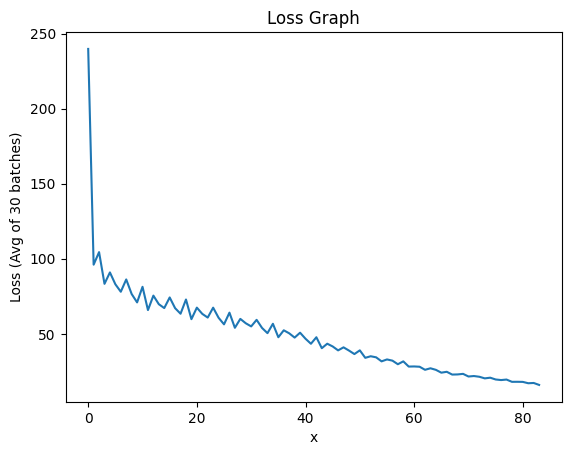

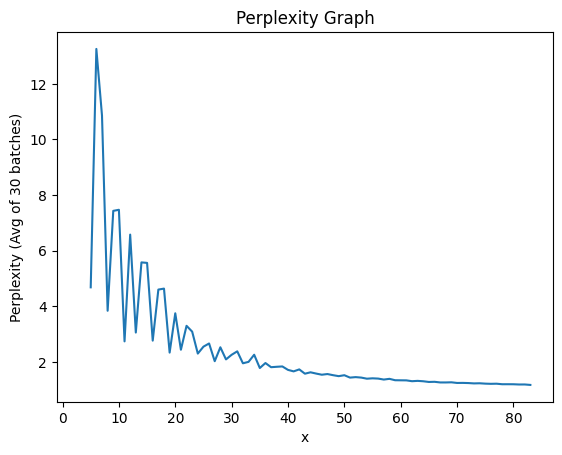

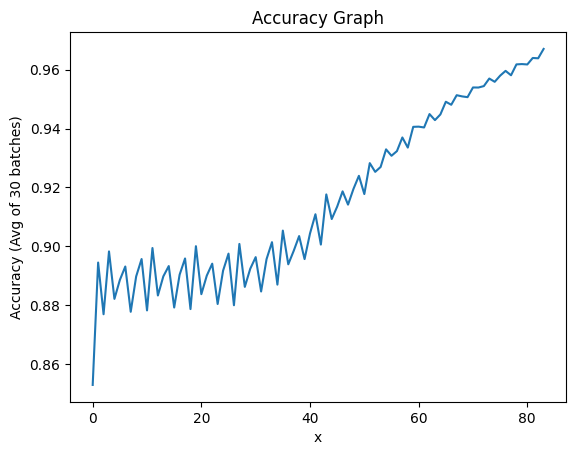

In [8]:
# Değerleri dosyadan oku
with open('avg_values.pkl', 'rb') as f:
    loaded_avg_loss, loaded_avg_acc, loaded_avg_perp = pickle.load(f)

# Yeniden atama
avg_loss = loaded_avg_loss
avg_acc = loaded_avg_acc
avg_perp = loaded_avg_perp

plt.plot(list(range(len(avg_loss))),avg_loss)
plt.xlabel("x")
plt.ylabel("Loss (Avg of 30 batches)")
plt.title("Loss Graph")
plt.show()

plt.plot(list(range(len(avg_perp))),avg_perp)
plt.xlabel("x")
plt.ylabel("Perplexity (Avg of 30 batches)")
plt.title("Perplexity Graph")
plt.show()

plt.plot(list(range(len(avg_acc))),avg_acc)
plt.xlabel("x")
plt.ylabel("Accuracy (Avg of 30 batches)")
plt.title("Accuracy Graph")
plt.show()